# MobileNet  (Process Images For Fine-Tuned MobileNet)

instead of vgg16 we use mobileNet

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [3]:
# instead of vgg16 we using mobileNet
mobile = tf.keras.applications.MobileNet()  # mobilenet download hunxa

 Now MobileNet was originally trained on the imageNet library just like vgg16.

In [4]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))   # resize the image
    img_array = image.img_to_array(img)  # putting it in array format
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)  # expand dimensions
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)  # MobileNet preprocessing and return processed image

In [ ]:
os.getcwd()

In [5]:
from IPython.display import Image
Image(filename="data/MobileNet-samples/1.jpg", width=300, height=200)

In [6]:
preprocessed_image = prepare_image('1.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  # return top 5 predictions
results

1/1 [==============================] - 1s 931ms/step


[[('n01682714', 'American_chameleon', 0.54783034),
  ('n01693334', 'green_lizard', 0.44969964),
  ('n01687978', 'agama', 0.0016098933),
  ('n01685808', 'whiptail', 0.00044924457),
  ('n01689811', 'alligator_lizard', 0.00015996219)]]

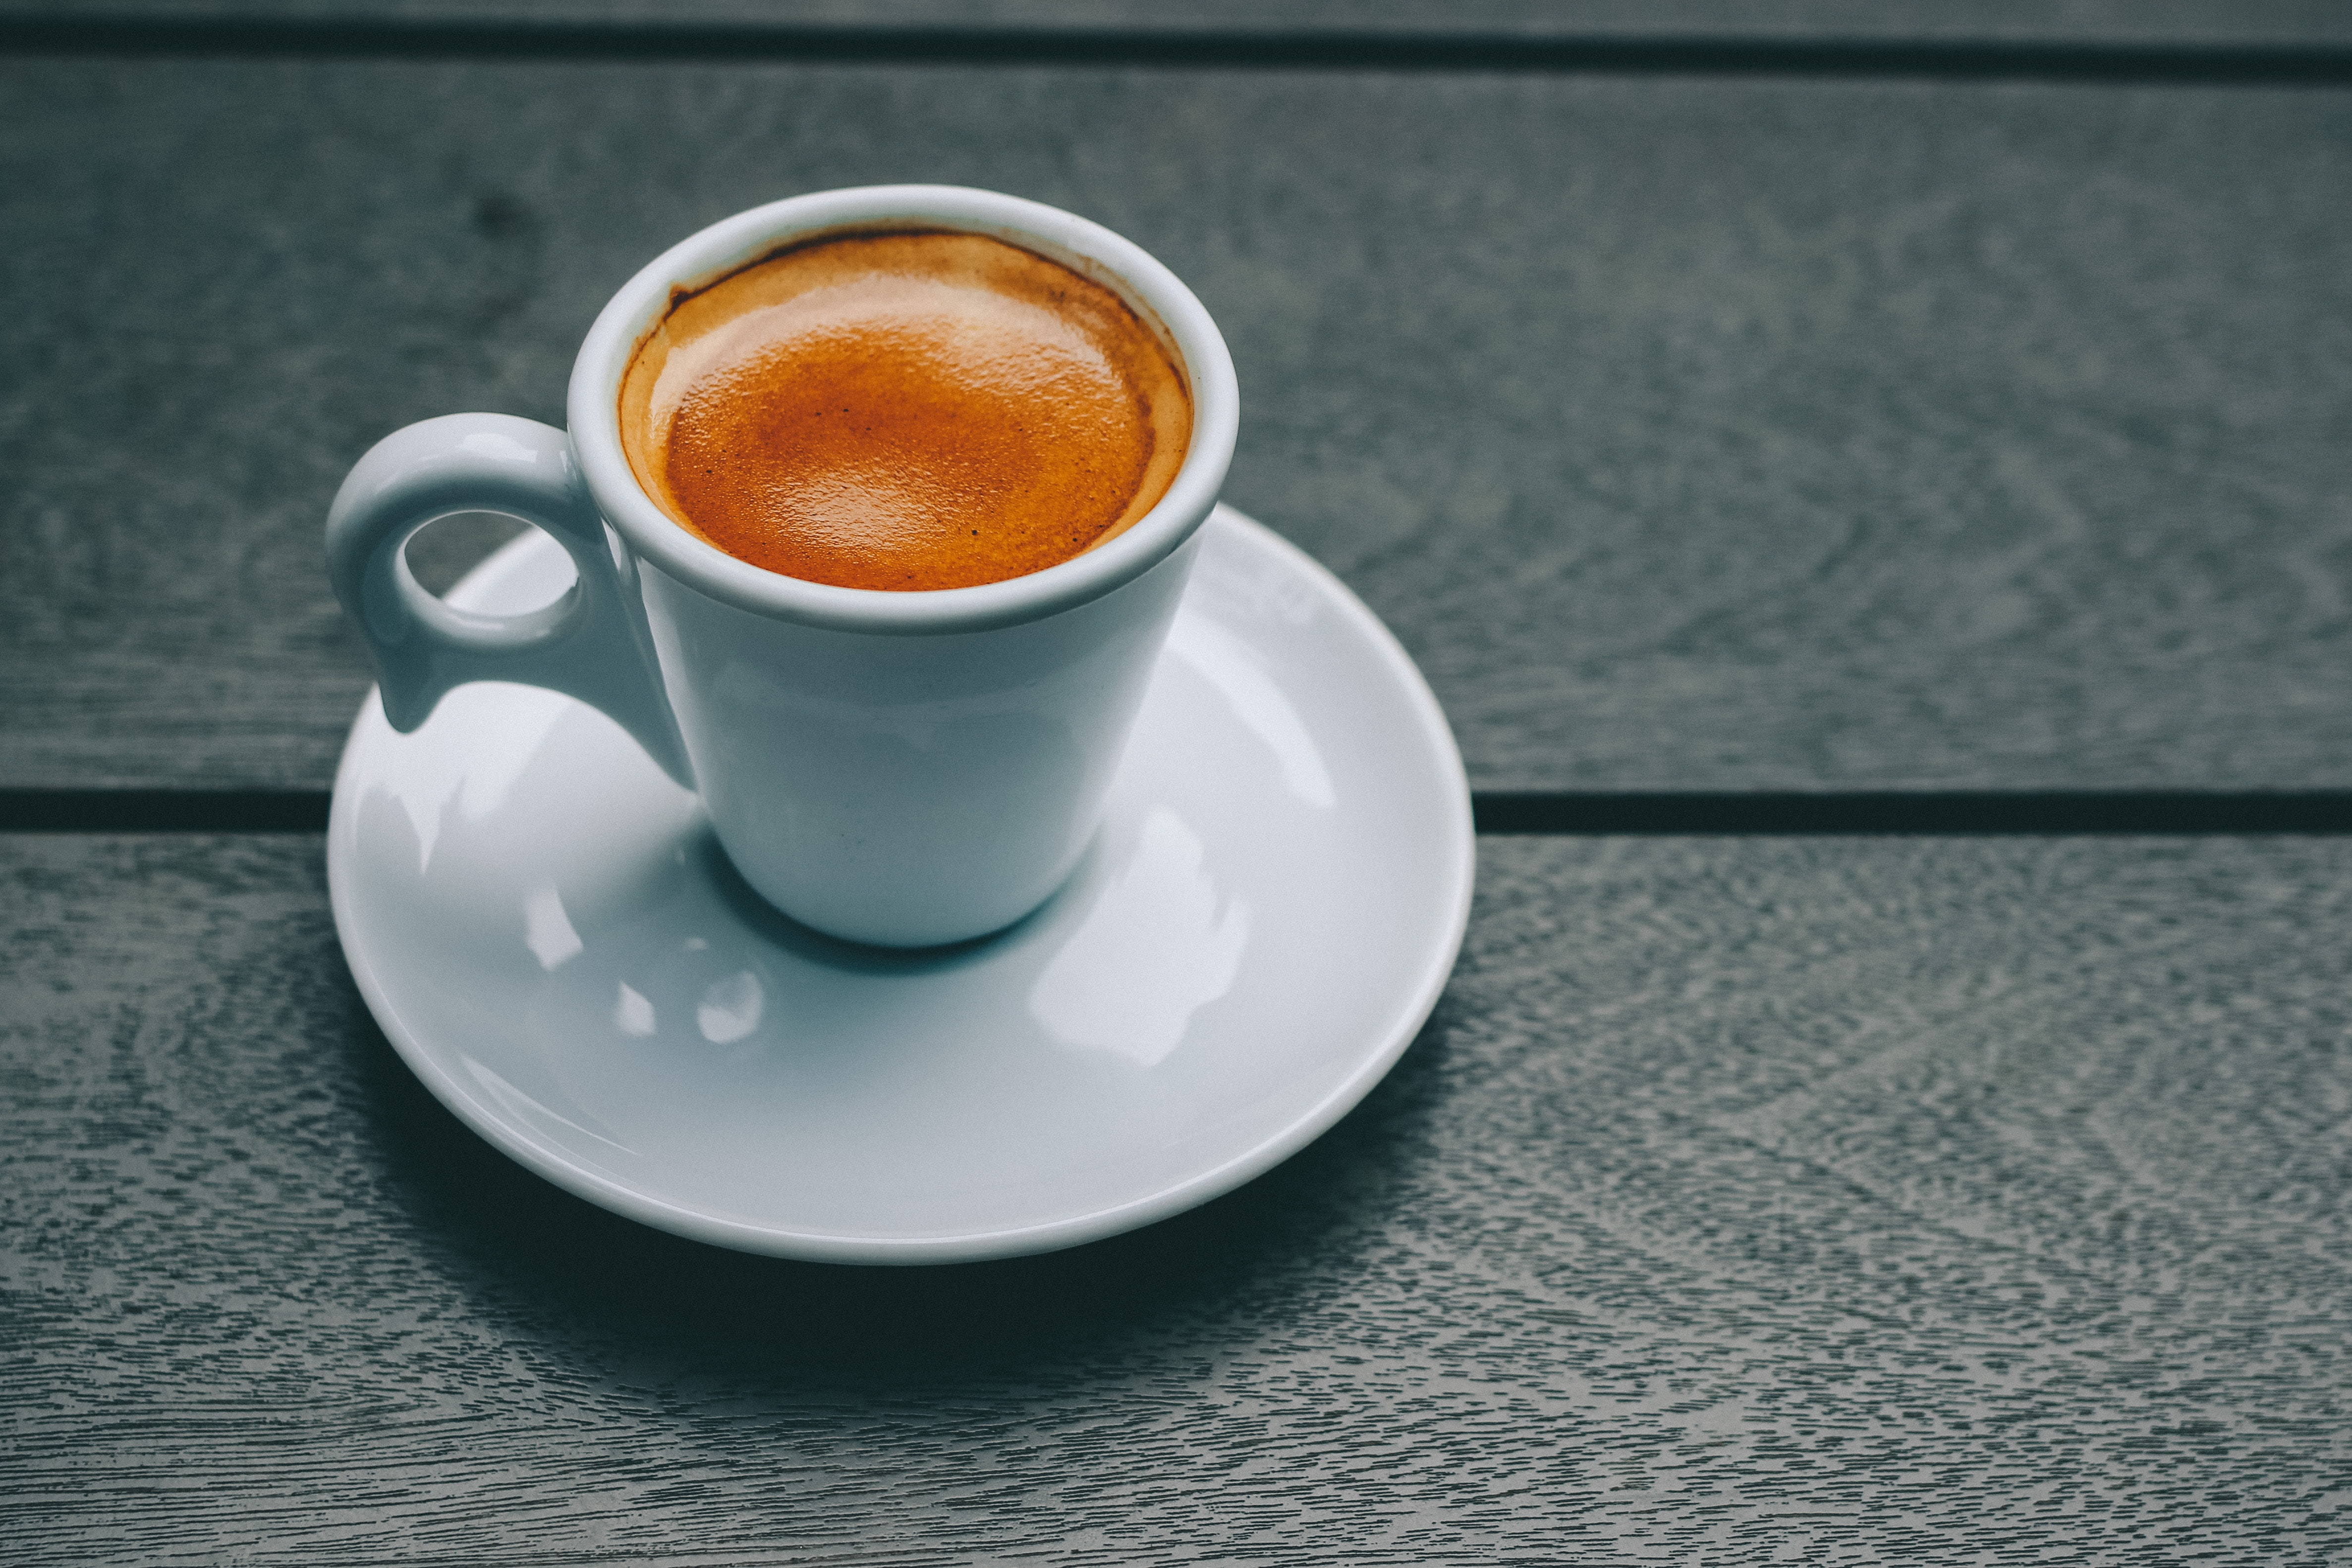

In [7]:
Image(filename='data/MobileNet-samples/2.jpg', width=300,height=200)

In [8]:
preprocessed_image = prepare_image('2.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 55ms/step


[[('n07920052', 'espresso', 0.95361143),
  ('n07930864', 'cup', 0.042990893),
  ('n03063599', 'coffee_mug', 0.0017986875),
  ('n03950228', 'pitcher', 0.0003740917),
  ('n03063689', 'coffeepot', 0.0003288185)]]

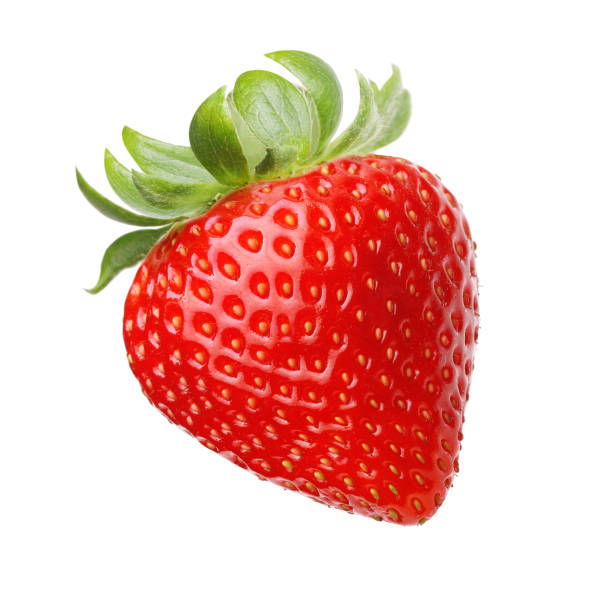

In [9]:
Image(filename='data/MobileNet-samples/3.jpg', width=300, height=200)

In [10]:
preprocessed_image = prepare_image('3.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 79ms/step


[[('n07745940', 'strawberry', 0.99577206),
  ('n04423845', 'thimble', 0.0013203409),
  ('n02948072', 'candle', 0.00026906183),
  ('n07742313', 'Granny_Smith', 0.0002386499),
  ('n04332243', 'strainer', 0.00022567161)]]

### Fine tune MobileNet using tensorflow keras API

We noticed that VGG16 was actually  already trained on cats and dogs, so it didn't take a lot of fine tuning at all to get it to perform well on our cat and dog dataset.

Now, with MobileNet, we'll be going through some fine tuning step as well.

#### working on the custom dataset "Sign-Language-Digits-Dataset"

In [ ]:
# Organize data into train, valid, test dirs
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(1, 10):
        shutil.move(f'{i}', 'train')  # moving 1 to 9 directories into train directory
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)  # randomly select "30" sample from "train/0" directory
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')  # move 30 sample from train/{i}/{j} to valid/{i}
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
            
os.chdir('../..')

In [11]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

In [12]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(244, 244), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(244, 244), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1542 images belonging to 9 classes.
Found 270 images belonging to 9 classes.
Found 45 images belonging to 9 classes.


### Modify Model (Build The Fine-Tuned Model)

In [27]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [28]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [29]:
x = mobile.layers[-5].output  # taking all the layers up to the sixth last
# output = Dense(units=10, activation="softmax")(x)  # to the output layer, pass all the previous layers that we have stored in X, upto this 6 to last layer and mobile net.

In [30]:
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=9, activation='softmax')(x)

In [31]:
model = Model(inputs=mobile.input, outputs=output)  # create model by calling "Model" using above output and input form original mobile net model.

In [32]:
# freeze, all except for the last 23 layers. (this saying that we want only the last 23 layers to be trainable. All the layer except the last for 23, make those not trainable)


for layer in model.layers[:-22]:
    layer.trainable = False

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

### Train the model

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Run for more epochs (~30) to see better results
# model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

In [37]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

Epoch 1/10
155/155 - 105s - loss: 0.6679 - accuracy: 0.7990 - val_loss: 0.4240 - val_accuracy: 0.8704 - 105s/epoch - 675ms/step
Epoch 2/10
155/155 - 93s - loss: 0.1122 - accuracy: 0.9825 - val_loss: 0.1637 - val_accuracy: 0.9630 - 93s/epoch - 600ms/step
Epoch 3/10
155/155 - 95s - loss: 0.0662 - accuracy: 0.9922 - val_loss: 0.0828 - val_accuracy: 0.9815 - 95s/epoch - 615ms/step
Epoch 4/10
155/155 - 102s - loss: 0.0333 - accuracy: 0.9974 - val_loss: 0.0535 - val_accuracy: 0.9815 - 102s/epoch - 660ms/step
Epoch 5/10
155/155 - 93s - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9889 - 93s/epoch - 601ms/step
Epoch 6/10
155/155 - 88s - loss: 0.0192 - accuracy: 0.9987 - val_loss: 0.0346 - val_accuracy: 0.9889 - 88s/epoch - 570ms/step
Epoch 7/10
155/155 - 91s - loss: 0.0145 - accuracy: 0.9987 - val_loss: 0.0331 - val_accuracy: 0.9889 - 91s/epoch - 589ms/step
Epoch 8/10
155/155 - 89s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9926 - 89s/epoch -

### Predict sign language digits 
Now we are going to predicts from the model on our test set

In [38]:
test_labels = test_batches.classes

In [39]:
predictions = model.predict(x=test_batches, verbose=0)  # "verbos=0" because we don't want to see any output from the predictions

In [40]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
test_batches.class_indices

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8}

In [43]:
# Train the model for more epochs to see better results
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 5]]


### Data Augmentation

Data augmentation occurs when we create a new data by making modifications to some existing. Data augmentation on images would include transformations like:

* Flipping the image either horizontally or vertically
* Rotating the image
* Zooming in or out on the image
* Cropping the image
* Varying the color on the image


One of the major reasons we want to use data augmentation is to simply just get access to more data. Lots of times that not having access to enough data is an issue that we can run into. And we can run into problems like overfitting if our training data set is too small.

Data Augmentation is to just grow our training set, adding augmented data to our training set can in turn reduce overfitting as well.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [45]:
# This function will plot images in the form of a grid with 1 row and 10 columns where image are
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show

In [46]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)

In [48]:
chosen_image = random.choice(os.listdir("data/cat-vs-dog/train/dog"))

In [51]:
image_path = 'data/cat-vs-dog/train/dog/' + chosen_image

In [52]:
assert os.path.isfile(image_path)

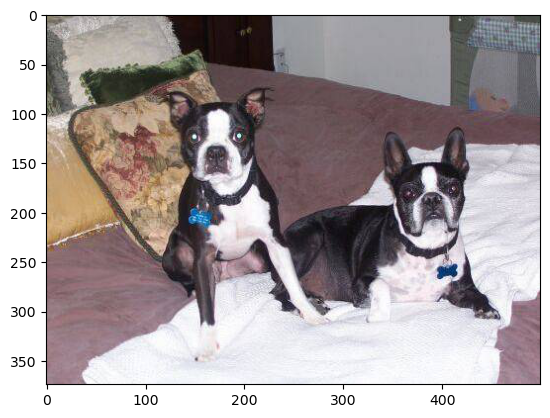

In [55]:
#optain image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [59]:
# Create an iterator using the datagen.flow() method
# aug_iter = gen.flow(image, batch_size=1)

In [61]:
# Generate batches of augmented images
aug_iter = gen.flow(image)

In [64]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

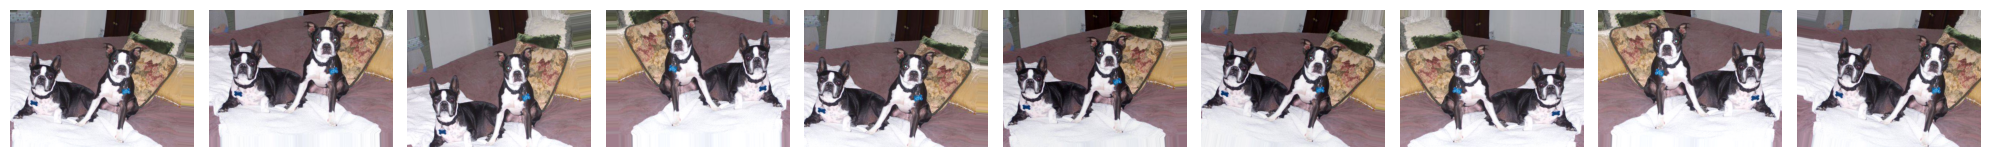

In [65]:
# Augmented images
plotImages(aug_images)